## Importing Libraries

1. `qiskit`: An open-source SDK took for working with quantum computers in python environment
2. `fractions`: This module supports rational number arithmetic

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import math
from fractions import Fraction
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

## Modelling Factorization Problem as Period Finding Problem

### Problem
$$ f(x) = a^{x}\mod N $$

In [16]:
def show_plot(N, a, _range):
  xvals = np.arange(_range)
  yvals = [np.mod(a**x, N) for x in xvals]
  fig, ax = plt.subplots(figsize=(15,3))
  ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
  ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$',
        title="Example of Periodic Function in Shor's Algorithm")
  try: # plot r on the graph
      r = yvals[1:].index(1) + 1
      plt.annotate('', xy=(0,1), xytext=(r,1),
                  arrowprops=dict(arrowstyle='<->'))
      plt.annotate(f'$r={r}$', xy=(r/3,1.5))
  except ValueError:
      print('Could not find period, check a < N and have no common factors.')

### Example 1:
$ N = 1007 $ <br>
$ a = 3 $

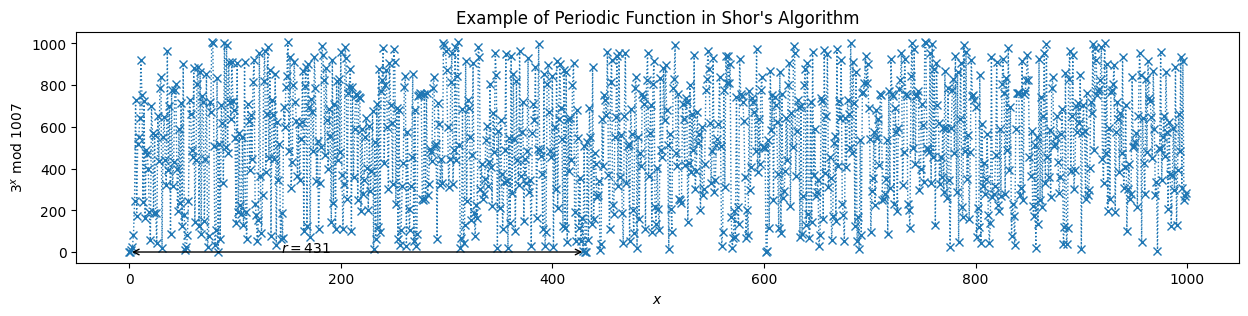

In [17]:
N = 1007
a = 3
show_plot(N, a, 1000)

### Example 2:
$ p = 7, q = 3 $ <br>
$ N = p * q = 7 * 3 = 21 $ <br>
$ a = 8 $

#### Explanation: 
$ 8^0 \equiv 1 \mod 21 $ <br>
$ 8^1 \equiv 8 \mod 21 $ <br>
$ 8^2 \equiv 1 \mod 21 $ <br>
$ 8^3 \equiv 8 \mod 21 $ <br>
$ 8^4 \equiv 1 \mod 21 $

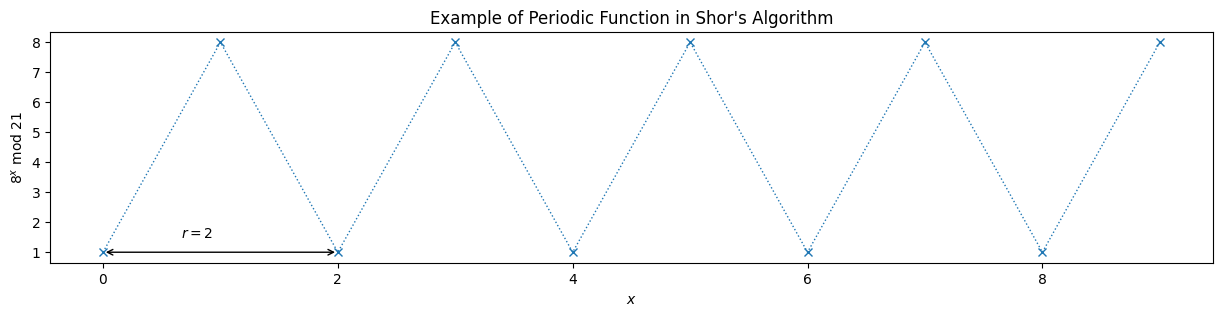

In [18]:
p,q = 7,3
N = p*q
a = 8
show_plot(N, a, 10)

In [19]:
def c_amod21(a, power):
    if a not in [2, 4, 5, 8, 10, 11, 13, 16, 17, 19, 20]:
        raise ValueError("'a' must be co-prime to 11") #2, 3, 4, 5, 6, 7, 8, 9, 10
    U = QuantumCircuit(4)
    for _iteration in range(power):
        U.swap(2,3)
        U.swap(1,2)
        U.swap(0,1)
        for q in range(4):  # Add X gates for these specific values
              U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 21"
    c_U = U.control()
    return c_U

In [20]:
N_COUNT = 8

In [21]:
def qft(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [22]:
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amod21(a, 2**q),
             [q] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc.append(qft(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw(fold=-1)  # -1 means 'do not fold'

┌───┐                                                                                                                             ┌───────┐┌─┐                     
 q_0: ┤ H ├───────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├┤M├─────────────────────
      ├───┤       │                                                                                                                     │       │└╥┘┌─┐                  
 q_1: ┤ H ├───────┼──────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─╫─┤M├──────────────────
      ├───┤       │              │                                                                                                      │       │ ║ └╥┘┌─┐               
 q_2: ┤ H ├───────┼──────────────┼──────────────■───────────────────────────────────────────────────────────────────────────────────────┤2      ├─╫──╫─┤M├───────────────
      ├───┤       │              │              │                                                                                       │       │ ║  ║ └╥┘┌─┐            
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■────────────────────────────────────────────────────────────────────────┤3      ├─╫──╫──╫─┤M├────────────
      ├───┤       │              │              │              │                                                                        │  QFT† │ ║  ║  ║ └╥┘┌─┐         
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────■─────────────────────────────────────────────────────────┤4      ├─╫──╫──╫──╫─┤M├─────────
      ├───┤       │              │              │              │              │                                                         │       │ ║  ║  ║  ║ └╥┘┌─┐      
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────■─────────────────────────────────────────┤5      ├─╫──╫──╫──╫──╫─┤M├──────
      ├───┤       │              │              │              │              │               │                                         │       │ ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────■─────────────────────────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├───
      ├───┤       │              │              │              │              │               │               │                         │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────┼────────────────■────────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├
      ├───┤┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐└───────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
 q_8: ┤ X ├┤0            ├┤0            ├┤0            ├┤0            ├┤0             ├┤0             ├┤0             ├┤0              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
      └───┘│             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├┤1             ├┤1             ├┤1             ├┤1              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │  8^1 mod 21 ││  8^2 mod 21 ││  8^4 mod 21 ││  8^8 mod 21 ││  8^16 mod 21 ││  8^32 mod 21 ││  8^64 mod 21 ││  8^128 mod 21 │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├┤2             ├┤2             ├┤2             ├┤2              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_11: ─────┤3            ├┤3            ├┤3            ├┤3            ├┤3             ├┤3       

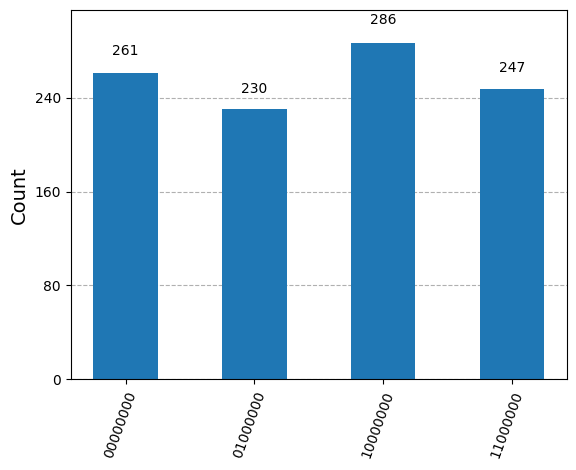

In [23]:
#aer_sim = AerProvider.get_backend(name='aer_simulator')
aer_sim = AerSimulator()
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

In [24]:
rows, measured_phases = [], []
rows.append(["Register Output", "Phase"])
for output in counts:
    decimal = int(output, 2)
    phase = decimal/(2**N_COUNT)
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Print the rows in a table
rows

[['Register Output', 'Phase'],
 ['00000000(bin) =   0(dec)', '0/256 = 0.00'],
 ['11000000(bin) = 192(dec)', '192/256 = 0.75'],
 ['10000000(bin) = 128(dec)', '128/256 = 0.50'],
 ['01000000(bin) =  64(dec)', '64/256 = 0.25']]

In [25]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(21)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.75      3/4            4
2   0.50      1/2            2
3   0.25      1/4            4


In [26]:
def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for _ in range(j):
        a = np.mod(a**2, N)
    return a

In [27]:
def qpe_amod21(a):
    """Performs quantum phase estimation on the operation a*r mod 15.
    Args:
        a (int): This is 'a' in a*r mod 15
    Returns:
        float: Estimate of the phase
    """
    N_COUNT = 8
    qc = QuantumCircuit(4+N_COUNT, N_COUNT)
    for q in range(N_COUNT):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(N_COUNT) # And auxiliary register in state |1>
    for q in range(N_COUNT): # Do controlled-U operations
        qc.append(c_amod21(a, 2**q),
                 [q] + [i+N_COUNT for i in range(4)])
    qc.append(qft(N_COUNT), range(N_COUNT)) # Do inverse-QFT
    qc.measure(range(N_COUNT), range(N_COUNT))
    # Simulate Results
    aer_sim = AerSimulator()
    # `memory=True` tells the backend to save each measurement in a list
    job = aer_sim.run(transpile(qc, aer_sim), shots=1, memory=True)
    readings = job.result().get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**N_COUNT)
    print(f"Corresponding Phase: {phase}")
    return phase

In [29]:
a = 8
FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nATTEMPT {ATTEMPT}:")
    phase = qpe_amod21(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print(f"Result: r = {r}")
    if phase != 0:
        guesses = [math.gcd(a**(r//2)-1, N), math.gcd(a**(r//2)+1, N)]
        print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                # Guess is a factor!
                print(f"*** Non-trivial factor found: {guess} ***")
                FACTOR_FOUND = True


ATTEMPT 1:
Register Reading: 01000000
Corresponding Phase: 0.25
Result: r = 4
Guessed Factors: 21 and 1

ATTEMPT 2:
Register Reading: 01000000
Corresponding Phase: 0.25
Result: r = 4
Guessed Factors: 21 and 1

ATTEMPT 3:
Register Reading: 00000000
Corresponding Phase: 0.0
Result: r = 1

ATTEMPT 4:
Register Reading: 00000000
Corresponding Phase: 0.0
Result: r = 1

ATTEMPT 5:
Register Reading: 01000000
Corresponding Phase: 0.25
Result: r = 4
Guessed Factors: 21 and 1

ATTEMPT 6:
Register Reading: 00000000
Corresponding Phase: 0.0
Result: r = 1

ATTEMPT 7:
Register Reading: 00000000
Corresponding Phase: 0.0
Result: r = 1

ATTEMPT 8:
Register Reading: 00000000
Corresponding Phase: 0.0
Result: r = 1

ATTEMPT 9:
Register Reading: 00000000
Corresponding Phase: 0.0
Result: r = 1

ATTEMPT 10:
Register Reading: 00000000
Corresponding Phase: 0.0
Result: r = 1

ATTEMPT 11:
Register Reading: 11000000
Corresponding Phase: 0.75
Result: r = 4
Guessed Factors: 21 and 1

ATTEMPT 12:
Register Reading: 0